# MLOps for NLP

## Understanding the problem 

## Setup

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [2]:
import ray 

In [3]:
# Initialize Ray 
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-06-20 10:02:49,838	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.12
Ray version:,2.24.0
Dashboard:,http://127.0.0.1:8266


In [4]:
ray.cluster_resources()

{'node:10.138.187.90': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 128.0,
 'object_store_memory': 200000000000.0,
 'memory': 842561899520.0}

In [5]:
num_workers = 1 
resources_per_workers = {"CPU": 3, "GPU": 1} 

## Data 

In [2]:
import pandas as pd

In [15]:
## Dataset link - https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
DATASET = './data/loan_approval_dataset.csv'

In [45]:
df = pd.read_csv(DATASET)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### Exploratory Data Analysis 

In [46]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns 

array([[<Axes: title={'center': 'loan_id'}>,
        <Axes: title={'center': ' no_of_dependents'}>,
        <Axes: title={'center': ' income_annum'}>],
       [<Axes: title={'center': ' loan_amount'}>,
        <Axes: title={'center': ' loan_term'}>,
        <Axes: title={'center': ' cibil_score'}>],
       [<Axes: title={'center': ' residential_assets_value'}>,
        <Axes: title={'center': ' commercial_assets_value'}>,
        <Axes: title={'center': ' luxury_assets_value'}>],
       [<Axes: title={'center': ' bank_asset_value'}>, <Axes: >,
        <Axes: >]], dtype=object)

<Figure size 2000x1200 with 0 Axes>

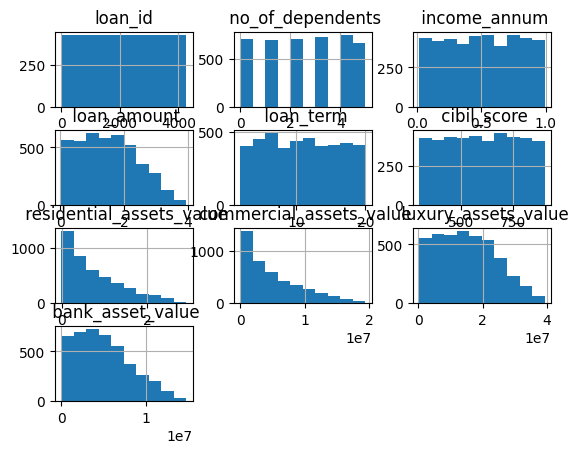

In [47]:
# Most commong tags
plt.figure(figsize = (20, 12));
df.hist()

In [48]:
# Renaming the column
df = df.rename(columns = {col_name: col_name.strip() for col_name in df.columns}) # Stripping the column name
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [49]:
df.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

In [50]:
df['education'].value_counts()

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

### Data Preprocessing

In [92]:
from sklearn.model_selection import train_test_split 

In [93]:
df.loan_status.value_counts()

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

In [94]:
df_processed = df.copy()

In [95]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'graduate':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['education'] = df_processed['education'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,0,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,1,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,1,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,0,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [96]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'approved':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['loan_status'] = df_processed['loan_status'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [97]:
# One hot encoding 
def convert_to_onehot(x):
    if x.strip().lower() == 'yes':    # 1 - Graduate, 0 Not Graduate    
        return 1 
    return 0 

df_processed['self_employed'] = df_processed['self_employed'].apply(convert_to_onehot)
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [98]:
# Log scaling

In [99]:
# Min max

#### Feature Engineering

In [100]:
df_processed['total_asset'] = df_processed['luxury_assets_value'] + df_processed['commercial_assets_value'] + df_processed['residential_assets_value'] 
df_processed.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_asset
0,1,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,42700000
1,2,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,13700000
2,3,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0,44900000
3,4,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0,44800000
4,5,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,50000000


## DVC

In [64]:
!dvc init --subdir

Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


In [67]:
!dvc add data/loan_approval_dataset.csv
!git add.dvc/config
!git commit -m "Added dataset"

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/akarx/MLOps/ML/.dvc/cache/files/md5'| |0/? [00:00<
                                                                                
!
  0%|          |Adding data/loan_approval_dataset.csv 0/1 [00:00<?,     ?file/s]
                                                                                
!
  0%|          |Checking out /home/akarx/MLOps/ML/data0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 49.55file/s]

To track the changes with git, run:

	git add data/loan_approval_dataset.csv.dvc data/.gitignore

To enable auto staging, run:

	dvc config core.autostage true
git: 'add.dvc/config' is not a git command. See 'git --help'.
On branch main
Your branch is ahead of 'origin/main' by 2 co

In [72]:
!dvc dag

+------------------------------------+ 
| data/loan_approval_dataset.csv.dvc | 
+------------------------------------+ 


## Experiment tracking with MLFlow

### Setting up mlflow

In [120]:
experiment_name = "loan approval"
mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.create_experiment(experiment_name)

'602423011611743124'

In [142]:
from xgboost import XGBClassifier 
import mlflow 
from sklearn.metrics import accuracy_score
from mlflow.models import infer_signature 

In [131]:
dataset = mlflow.data.from_pandas(
    df_processed, name="Loan Approval Dataset", targets="loan_status"
)

In [132]:
test_size = 0.2 
train_df, val_df = train_test_split(df_processed, stratify=df.loan_status, test_size=test_size, random_state=1234) 

In [133]:
X_train = train_df.drop(columns = ['loan_status'], axis = 1) 
y_train = train_df['loan_status']

In [134]:
X_val = val_df.drop(columns = ['loan_status'], axis = 1) 
y_val = val_df['loan_status']

In [135]:
xgb_classifier = XGBClassifier(
    n_estimators=10, 
    max_depth=3, 
    learning_rate=1, 
    objective="binary:logistic", 
    random_state=123, 
)


In [136]:
with mlflow.start_run():
    mlflow.log_input(dataset, context="training")
    xgb_classifier.fit(X_train, y_train) 
    clf_params = xgb_classifier.get_xgb_params() 
    mlflow.log_params(clf_params) 
    signature = infer_signature(X_train, xgb_classifier.predict(X_train))   # What is this infer_signature
    model_info = mlflow.xgboost.log_model(
        xgb_classifier, "loan classification", signature=signature
    ) 
    y_pred = xgb_classifier.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    mlflow.log_metric("accuracy", acc)


/home/akarx/MLOps/mlops_venv/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/akarx/MLOps/mlops_venv/lib/python3.10/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data cont

In [137]:
xgb_classifier_saved = mlflow.pyfunc.load_model(model_info.model_uri) 
y_pred = xgb_classifier_saved.predict(X_val)

In [138]:
y_pred

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [143]:
acc = accuracy_score(y_val, y_pred)
mlflow.log_metric("accuracy", acc)

## Hyperparameters tuning using optuna

In [147]:
import math 
import numpy as np 
import seaborn as sns
import xgboost as xgb

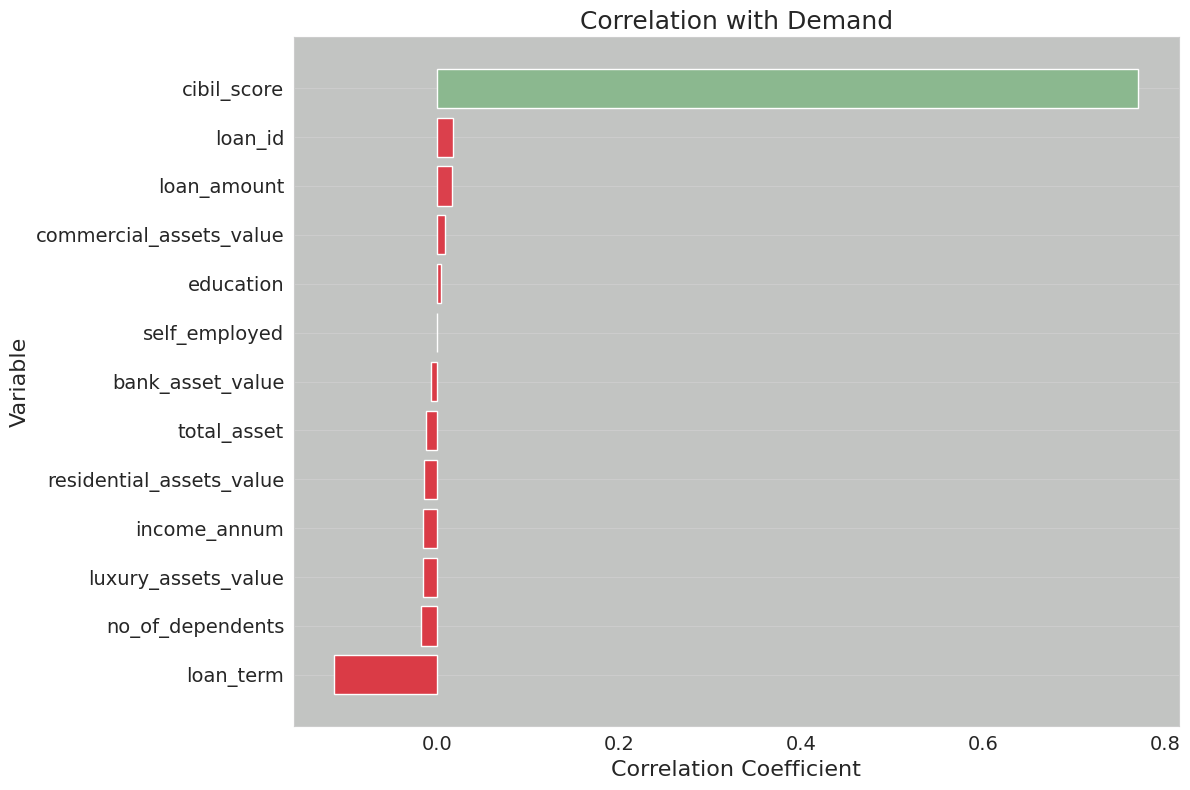

In [102]:
def plot_correlation(df, save_path=None): 
    """
    Plots the correlation of each variable in the dataframe with the demand column
    """
    correlations = df.corr()['loan_status'].drop('loan_status').sort_values()
    colors = sns.diverging_palette(10, 130, as_cmap=True) 
    color_mapped = correlations.map(colors) 

    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )

    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped) 

    plt.title("Correlation with Demand", fontsize=18) 
    plt.xlabel("Correlation Coefficient", fontsize=16) 
    plt.ylabel("Variable", fontsize=16) 
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.grid(axis="x")

    plt.tight_layout()

    plt.show()

plot_correlation(df_processed)
    

In [145]:
def plot_feature_importance(model, booster): 
    """
    Plost feature importance for an XGBoost model.
    """ 
    fig, ax = plt.subplots(figsize=(10, 8)) 
    importance_type = "weight" if booster == "gblinear" else "gain" 
    xgboost.plot_importance(
        model, 
        importance_type=importance_type, 
        ax=ax, 
        title=f"Feature Importance based on {importance_type}", 
    )
    plt.tight_layout() 
    plt.show()


In [149]:
dtrain = xgb.DMatrix(X_train, label=y_train) 
dvalid = xgb.DMatrix(X_val, label=y_val) 

In [150]:
with mlflow.start_run(nested=True, run_name="hyperparameter_tuning"):
    
    study = optuna.create_study(direction='minimize')
    
    params = {
        "objective": "binary:logistic", 
        "eval_metric": "accuracy", 
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]), 
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True), 
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True) 
    } 

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )
    bst = xgb.train(params, dtrain) 
    preds = bst.predict(dvalid) 
    acc = accuracy_score(y_val, preds)

    mlflow.log_params(params)
    mlflow.log_metric("accuracy", acc)
    

NameError: name 'trial' is not defined

### Setting up ray

In [32]:
import ray 

In [33]:
if ray.is_initialized():
    ray.shutdown()

ray.init()

2024-06-19 06:16:14,762	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.24.0
Dashboard:,http://127.0.0.1:8265


(ProxyActor pid=3286421) INFO 2024-06-19 06:16:17,880 proxy 192.168.50.196 proxy.py:1165 - Proxy starting on node d51a5cf6d9f3474daef0be87b2fe9ace8195b616b742a19f472e5bee (HTTP port: 8000).
(ServeController pid=3286323) INFO 2024-06-19 06:16:18,043 controller 3286323 deployment_state.py:1598 - Deploying new version of Deployment(name='Translator', app='default') (initial target replicas: 2).
(ServeController pid=3286323) INFO 2024-06-19 06:16:18,151 controller 3286323 deployment_state.py:1844 - Adding 2 replicas to Deployment(name='Translator', app='default').
(raylet) [2024-06-19 06:16:23,731 E 3274145 3274183] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-19_06-16-12_106407_3141861 is over 95% full, available space: 19610648576; capacity: 941289119744. Object creation will fail if spilling is required.
(raylet) [2024-06-19 06:16:33,748 E 3274145 3274183] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-19_06-16-12_106407_3141861 is over 95% full, availabl

In [34]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'object_store_memory': 73128705638.0,
 'memory': 160633646490.0,
 'CPU': 224.0,
 'node:192.168.50.196': 1.0}

In [35]:
num_workers = 2 
resources_per_worker = {"CPU": 4}


In [36]:
from starlette.requests import Request

import ray
from ray import serve

In [37]:
from transformers import pipeline 

@serve.deployment(num_replicas=2, ray_actor_options={'num_cpus':0.2, 'num_gpus':0})
class Translator:
    def __init__(self):
        self.model = pipeline("translation_en_to_fr", model="t5-small")

    def translate(self, text: str) -> str:
        model_output = self.model(text)
        translation = model_output[0]['translation_text'] 
        return translation

    async def __call__(self, http_request: Request) -> str:
        english_text: str = await http_request.json() 
        return self.translate(english_text) 


In [38]:
translator_app = Translator.bind()

In [39]:
serve.run(translator_app)

2024-06-19 06:16:17,938	INFO handle.py:126 -- Created DeploymentHandle 'b3tp7nce' for Deployment(name='Translator', app='default').
2024-06-19 06:16:17,940	INFO handle.py:126 -- Created DeploymentHandle '8lbigl0q' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,186	INFO handle.py:126 -- Created DeploymentHandle 'vuvbxp6x' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,189	INFO api.py:584 -- Deployed app 'default' successfully.
2024-06-19 06:16:47,203	INFO handle.py:126 -- Created DeploymentHandle 'jhc0h6jo' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,205	INFO handle.py:126 -- Created DeploymentHandle 'n8d30n16' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,207	INFO handle.py:126 -- Created DeploymentHandle '2dvvpy6b' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,209	INFO handle.py:126 -- Created DeploymentHandle 'h5cuvxbr' for Deployment(name='Translator', app='default

DeploymentHandle(deployment='Translator')

In [40]:
import requests

english_text = "Hello world!"

response = requests.post("http://127.0.0.1:8000/", json=english_text)
french_text = response.text

print(french_text)

Bonjour monde!


In [43]:
import time 
for i in range(100):
    st = time.time()
    response = requests.post("http://127.0.0.1:8000/", json=english_text)
    french_text = response.text
    stop_time = time.time()
    
    print("Time taken : ", stop_time - st)
    
    

Time taken :  0.25975513458251953
Time taken :  0.768261194229126
Time taken :  0.2558901309967041
Time taken :  0.2621164321899414
Time taken :  0.24512028694152832
Time taken :  0.272705078125
Time taken :  0.24981236457824707
Time taken :  0.2615053653717041
Time taken :  0.2790205478668213
Time taken :  0.25559377670288086
Time taken :  0.24851346015930176
Time taken :  0.24480414390563965
Time taken :  0.26859092712402344
Time taken :  0.23463034629821777
Time taken :  0.26082420349121094
Time taken :  0.24360299110412598
Time taken :  0.24718356132507324
Time taken :  0.2480611801147461
Time taken :  0.25154757499694824
Time taken :  0.2278296947479248
Time taken :  0.22254419326782227
Time taken :  0.21743106842041016
Time taken :  0.23230504989624023
Time taken :  0.24234509468078613
Time taken :  0.2277991771697998
Time taken :  0.22005319595336914
Time taken :  0.21160531044006348
Time taken :  0.2005312442779541
Time taken :  0.19638991355895996
Time taken :  0.2244181632995